# Objetivos del proyecto.

Vamos a analizar un conjunto de datos de la Universidad de Wisconsin, que contiene información sobre pacientes con posible cáncer de mama, junto con su clasificación (diagnóstico positivo o negativo).

Nuestro objetivo será entrenar y comparar diversos modelos de conjunto (ensemble models) para evaluar su desempeño.

Dado que este es un problema de diagnóstico médico, priorizaremos la métrica de recall de la clase positiva ('Malignant'), definida como: $$Recall_{Malignant}=\frac{True positives}{True positives + False Negatives},$$ ya que tiene más importancia detectar todos los posibles casos de cancer aunque esto nos lleve a dar algún falso positivo. Esta métrica se suele llamar sensibilidad en un contexto estadístico clásico.

_Es importante notar que en la práctica clínica moderna, el sobrediagnóstico del cáncer de mama es un tema muy importante. Detectar un cáncer que nunca habría causado síntomas o problemas en la vida de la paciente puede llevar a tratamientos innecesarios. De hecho, el sobrediagnóstico es actualmente uno de los principales inconvenientes de la práctica extendida de mamografías. Para más información, véase el artículo:  https://pmc.ncbi.nlm.nih.gov/articles/PMC5365181/#:~:text=Overdiagnosis%20(overdetection)%20of%20BC%20from,side%20of%20population%20breast%20screening._

En este proyecto, no solo nos interesa la precisión del modelo con respecto a métricas estándar, sino que también es fundamental evaluar su interpretabilidad. En sectores como la salud (y en áreas financieras como la concesión de préstamos hipotecarios), es indispensable entender por qué un modelo toma ciertas decisiones. Para lograrlo, utilizaremos la técnica de **Shapley Values**, que permite explicar la contribución de cada variable en las predicciones. Además, exploraremos otras técnicas complementarias para mejorar el análisis de las decisiones del modelo.

# Paquetes

En esta sección simplemente cargaremos todos los paquetes necesarios para llevar a cabo el análisis.

In [119]:
# Load libraries
from typing import Tuple
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

# Cargando y explicando el dataset

A continuación cargamos el dataset y sus metadatos para analizarlo.

In [120]:
from ucimlrepo import fetch_ucirepo 
  

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

print(breast_cancer_wisconsin_diagnostic.metadata) 
   
print(breast_cancer_wisconsin_diagnostic.variables) 

df = pd.concat([X, y], axis=1)
df['Diagnosis']=df['Diagnosis'].map({'M': 1, 'B': 0})

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

Puesto que los metadatos no contienen demasiada información, vamos a explicar un poco las caracterisitcas de este conjunto de datos. Los detalles que se presentan a continuación pueden encontrarse en:https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic.

# Conjunto de Datos: Breast Cancer Wisconsin (Diagnostic)

El conjunto de datos **Breast Cancer Wisconsin (Diagnostic)** contiene información derivada de imágenes digitalizadas de aspiraciones con aguja fina (**FNA**) de masas mamarias.  
Cada instancia representa características de los núcleos celulares presentes en la imagen.

## Columnas del Conjunto de Datos

### Identificación y Diagnóstico
- **ID**: Número de identificación del paciente.
- **Diagnóstico**: Clasificación del tumor, donde **"M"** indica maligno y **"B"** indica benigno.

### Características de los Núcleos Celulares
Para cada núcleo celular, se calcularon **10 características reales**:

1. **Radio**: Promedio de las distancias desde el centro hasta los puntos en el perímetro.
2. **Textura**: Desviación estándar de los valores de escala de grises.
3. **Perímetro**: Longitud del perímetro del núcleo.
4. **Área**: Área del núcleo.
5. **Suavidad**: Variación local en las longitudes del radio.
6. **Compacidad**: $ \text{Perímetro}^2 / \text{Área} - 1.0 .$
7. **Concavidad**: Severidad de las porciones cóncavas del contorno.
8. **Puntos cóncavos**: Número de porciones cóncavas del contorno.
9. **Simetría**: Simetría del núcleo.
10. **Dimensión fractal**: "Aproximación de la línea de costa" - 1.

### Valores Calculados para Cada Característica
Para cada una de estas 10 características, se calcularon **tres valores**:

- **Media**: Valor promedio de la característica.  
- **Error estándar**: Desviación estándar de la característica.  
- **Peor valor**: Mayor valor observado (promedio de los tres valores más grandes).  

Esto da lugar a un total de **30 columnas de características** en el conjunto de datos.

### Ejemplo de Columnas en el Dataset

| Tipo | Radio | Textura | Perímetro |
|------|-------|---------|-----------|
| **Media** | `radius_mean` | `texture_mean` | `perimeter_mean` |
| **Error estándar** | `radius_se` | `texture_se` | `perimeter_se` |
| **Peor valor** | `radius_worst` | `texture_worst` | `perimeter_worst` |

Y así sucesivamente para las demás características.

Puesto que queda mucho más claro tener los nombres con _mean _se y _worst en lugar de 1 2 y 3, los sustituimos a continuación.


In [121]:
df.columns = df.columns.str.replace('1', '_mean').str.replace('2', '_se').str.replace('3', '_worst')
print(df.shape)
df.head()


(569, 31)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,...,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119,1
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,...,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089,1
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,...,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088,1
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,...,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173,1
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,...,16.67,152.20,1575.0,0.137,0.205,0.400,0.163,0.236,0.077,1


Vamos también a guardar los subconjuntos de columnas en variables para usarlas durante el resto del proyecto.

In [122]:
mean_columns = [col for col in df.columns if col.endswith('_mean')]
se_columns = [col for col in df.columns if col.endswith('_se')]
worst_columns = [col for col in df.columns if col.endswith('_worst')]
features=mean_columns+se_columns+worst_columns

target='Diagnosis'

# Fase preprocesado

## Estadistica basica

In [123]:
pd.set_option('display.precision', 3)
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,14.127,19.290,91.969,654.889,0.096,0.104,0.089,0.049,0.181,0.063,...,25.677,107.261,880.583,0.132,0.254,0.272,0.115,0.290,0.084,0.373
std,3.524,4.301,24.299,351.914,0.014,0.053,0.080,0.039,0.027,0.007,...,6.146,33.603,569.357,0.023,0.157,0.209,0.066,0.062,0.018,0.484
min,6.981,9.710,43.790,143.500,0.053,0.019,0.000,0.000,0.106,0.050,...,12.020,50.410,185.200,0.071,0.027,0.000,0.000,0.157,0.055,0.000
25%,11.700,16.170,75.170,420.300,0.086,0.065,0.030,0.020,0.162,0.058,...,21.080,84.110,515.300,0.117,0.147,0.115,0.065,0.250,0.071,0.000
50%,13.370,18.840,86.240,551.100,0.096,0.093,0.062,0.034,0.179,0.062,...,25.410,97.660,686.500,0.131,0.212,0.227,0.100,0.282,0.080,0.000
75%,15.780,21.800,104.100,782.700,0.105,0.130,0.131,0.074,0.196,0.066,...,29.720,125.400,1084.000,0.146,0.339,0.383,0.161,0.318,0.092,1.000
max,28.110,39.280,188.500,2501.000,0.163,0.345,0.427,0.201,0.304,0.097,...,49.540,251.200,4254.000,0.223,1.058,1.252,0.291,0.664,0.207,1.000


In [124]:
# class distribution
df.groupby('Diagnosis').size()

Diagnosis
0    357
1    212
dtype: int64

### train test split

Vamos a dividir nuestro conjunto de datos en entrenamiento y test antes de la visualización y análisis exploratorio. Aunque podríamos hacerlo después, he decidido hacerlo en este punto porque utilizaré las visualizaciones y el análisis de correlaciones para una selección preliminar de variables. Al hacerlo antes, evitamos el data leakage, es decir, la contaminación del conjunto de entrenamiento con información del test, lo que garantizará que cualquier insight obtenido provenga únicamente de los datos con los que entrenaremos el modelo.

Dado que, según la descripción de los datos, es probable que existan altas correlaciones entre muchas variables, este análisis debe realizarse con el apoyo de un experto en el dominio (en este caso, un oncólogo especializado en cáncer de mama). La razón es que, aunque algunas características estén altamente correlacionadas, pueden capturar matices clínicos distintos que queramos preservar. Además, en ciertos casos, conservar variables redundantes puede ser útil para mejorar la robustez del modelo frente a la pérdida de datos. Un ejemplo clásico es la medición de la presión arterial: si tenemos la presión arterial sistólica (PAS), la diastólica (PAD) y la presión de pulso (PAS - PAD), eliminar una de ellas por alta correlación podría hacer que el modelo sea menos resiliente si alguna medición estuviera ausente o fuera errónea.

Si bien la presencia de correlaciones no afecta el poder predictivo de los modelos que utilizaremos, sí influye en su interpretabilidad. En particular, en algoritmos como los bosques aleatorios, la importancia de las variables (feature importance) puede verse distorsionada, ya que el modelo tiende a seleccionar aleatoriamente una de entre varias características altamente correlacionadas, subestimando la relevancia real de estas variables.

Por todas estas razones, optamos por realizar la división antes del análisis exploratorio. Esto nos permitirá trabajar con una muestra representativa del conjunto de entrenamiento y garantizar que cualquier selección de variables o transformación realizada se base exclusivamente en los datos disponibles para el entrenamiento del modelo, evitando sesgos y fugas de información.

In [158]:
X_train, X_test, y_train, y_test= train_test_split(df[features],df[target],test_size=0.2)

In [160]:
scaler= StandardScaler()

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


X_train_scaled = pd.DataFrame(scaler.fit_transform(df_train[features]), columns=features, index=df_train.index) 
X_test_scaled = pd.DataFrame(scaler.transform(df_test[features]), columns=features, index=df_test.index)  


# Reconstruct scaled df_train
df_train_scaled = pd.concat([X_train_scaled, y_train], axis=1)
df_test_scaled= pd.concat([X_test_scaled, y_test], axis=1)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(455, 30) (455,)
(114, 30) (114,)


## Visualización

In [127]:
def violin_plotter(df: pd.DataFrame, features: list, split_column : str =None, palette : dict =None, ax=None) -> None:
    """
    Creates violin plots for the given features, standardized, optionally grouped by a categorical column.
    Supports subplotting for side-by-side comparisons.

    Parameters:
    - df (DataFrame): The dataset containing numerical features.
    - features (list): List of feature names to plot.
    - split_column (str, optional): Column used to split the violin plots. If None, plots without classes.
    - palette (dict, optional): Dictionary defining colors for categories in the split_column.
    - ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib subplot axis for side-by-side plotting.

    Returns:
    - None (Displays the violin plot inside the given subplot).
    """

    df = df.copy()  # Avoid modifying the original dataset

    # Standardize the features
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df_scaled[features])

    # Reshape data for Seaborn (Melt the dataframe)
    if split_column and split_column in df.columns:
        df_scaled[split_column] = df_scaled[split_column].astype('category')  # Ensure categorical type
        df_melted = df_scaled.melt(id_vars=[split_column], value_vars=features, 
                                   var_name="Feature", value_name="Standardized Value")
    else:
        df_melted = df_scaled.melt(value_vars=features, var_name="Feature", value_name="Standardized Value")
        split_column = None  # Ensure it's set to None for plotting

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6)) 

    # Create the violin plot
    if split_column:
        sns.violinplot(x="Feature", y="Standardized Value", hue=split_column, data=df_melted, 
                       split=True, inner="quartile", palette=palette, ax=ax)
        ax.legend(title=split_column)
    else:
        sns.violinplot(x="Feature", y="Standardized Value", data=df_melted, inner="quartile", color="skyblue", ax=ax)

    # Improve aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title("Standardized Distribution of Features" + (f" by {split_column}" if split_column else ""))
    return None


def swarm_plotter(df: pd.DataFrame, features: list, split_column : str =None, ax=None, palette : dict =None) -> None:
    """
    Creates swarm plots for the given features, standardized, optionally grouped by a categorical column.
    Supports subplotting for side-by-side comparisons.

    Parameters:
    - df (DataFrame): The dataset containing numerical features.
    - features (list): List of feature names to plot.
    - split_column (str, optional): Column used to split the violin plots. If None, plots without classes.
    - palette (dict, optional): Dictionary defining colors for categories in the split_column.
    - ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib subplot axis for side-by-side plotting.

    Returns:
    - None (Displays the violin plot inside the given subplot).
    """

    df = df.copy()  # Avoid modifying the original dataset

    # Standardize the features
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df_scaled[features])

    # Reshape data for Seaborn (Melt the dataframe)
    if split_column and split_column in df.columns:
        df_scaled[split_column] = df_scaled[split_column].astype('category')  # Ensure categorical type
        df_melted = df_scaled.melt(id_vars=[split_column], value_vars=features, 
                                   var_name="Feature", value_name="Standardized Value")
    else:
        df_melted = df_scaled.melt(value_vars=features, var_name="Feature", value_name="Standardized Value")
        split_column = None  # Ensure it's set to None for plotting

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6)) 

    # Create the violin plot
    if split_column:
        sns.swarmplot(x="Feature", y="Standardized Value", hue=split_column, data=df_melted, ax=ax, palette=palette)
        ax.legend(title=split_column)

        #sns.swarmplot(x="Feature", y="Standardized Value", hue=split_column, data=df_melted, 
        #               split=True, palette=palette, ax=ax)
        #ax.legend(title=split_column)
    else:
        sns.swarmplot(x="Feature", y="Standardized Value", data=df_melted, color="skyblue", ax=ax, palette=palette)

    # Improve aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title("Standardized Distribution of Features" + (f" by {split_column}" if split_column else ""))
    return None


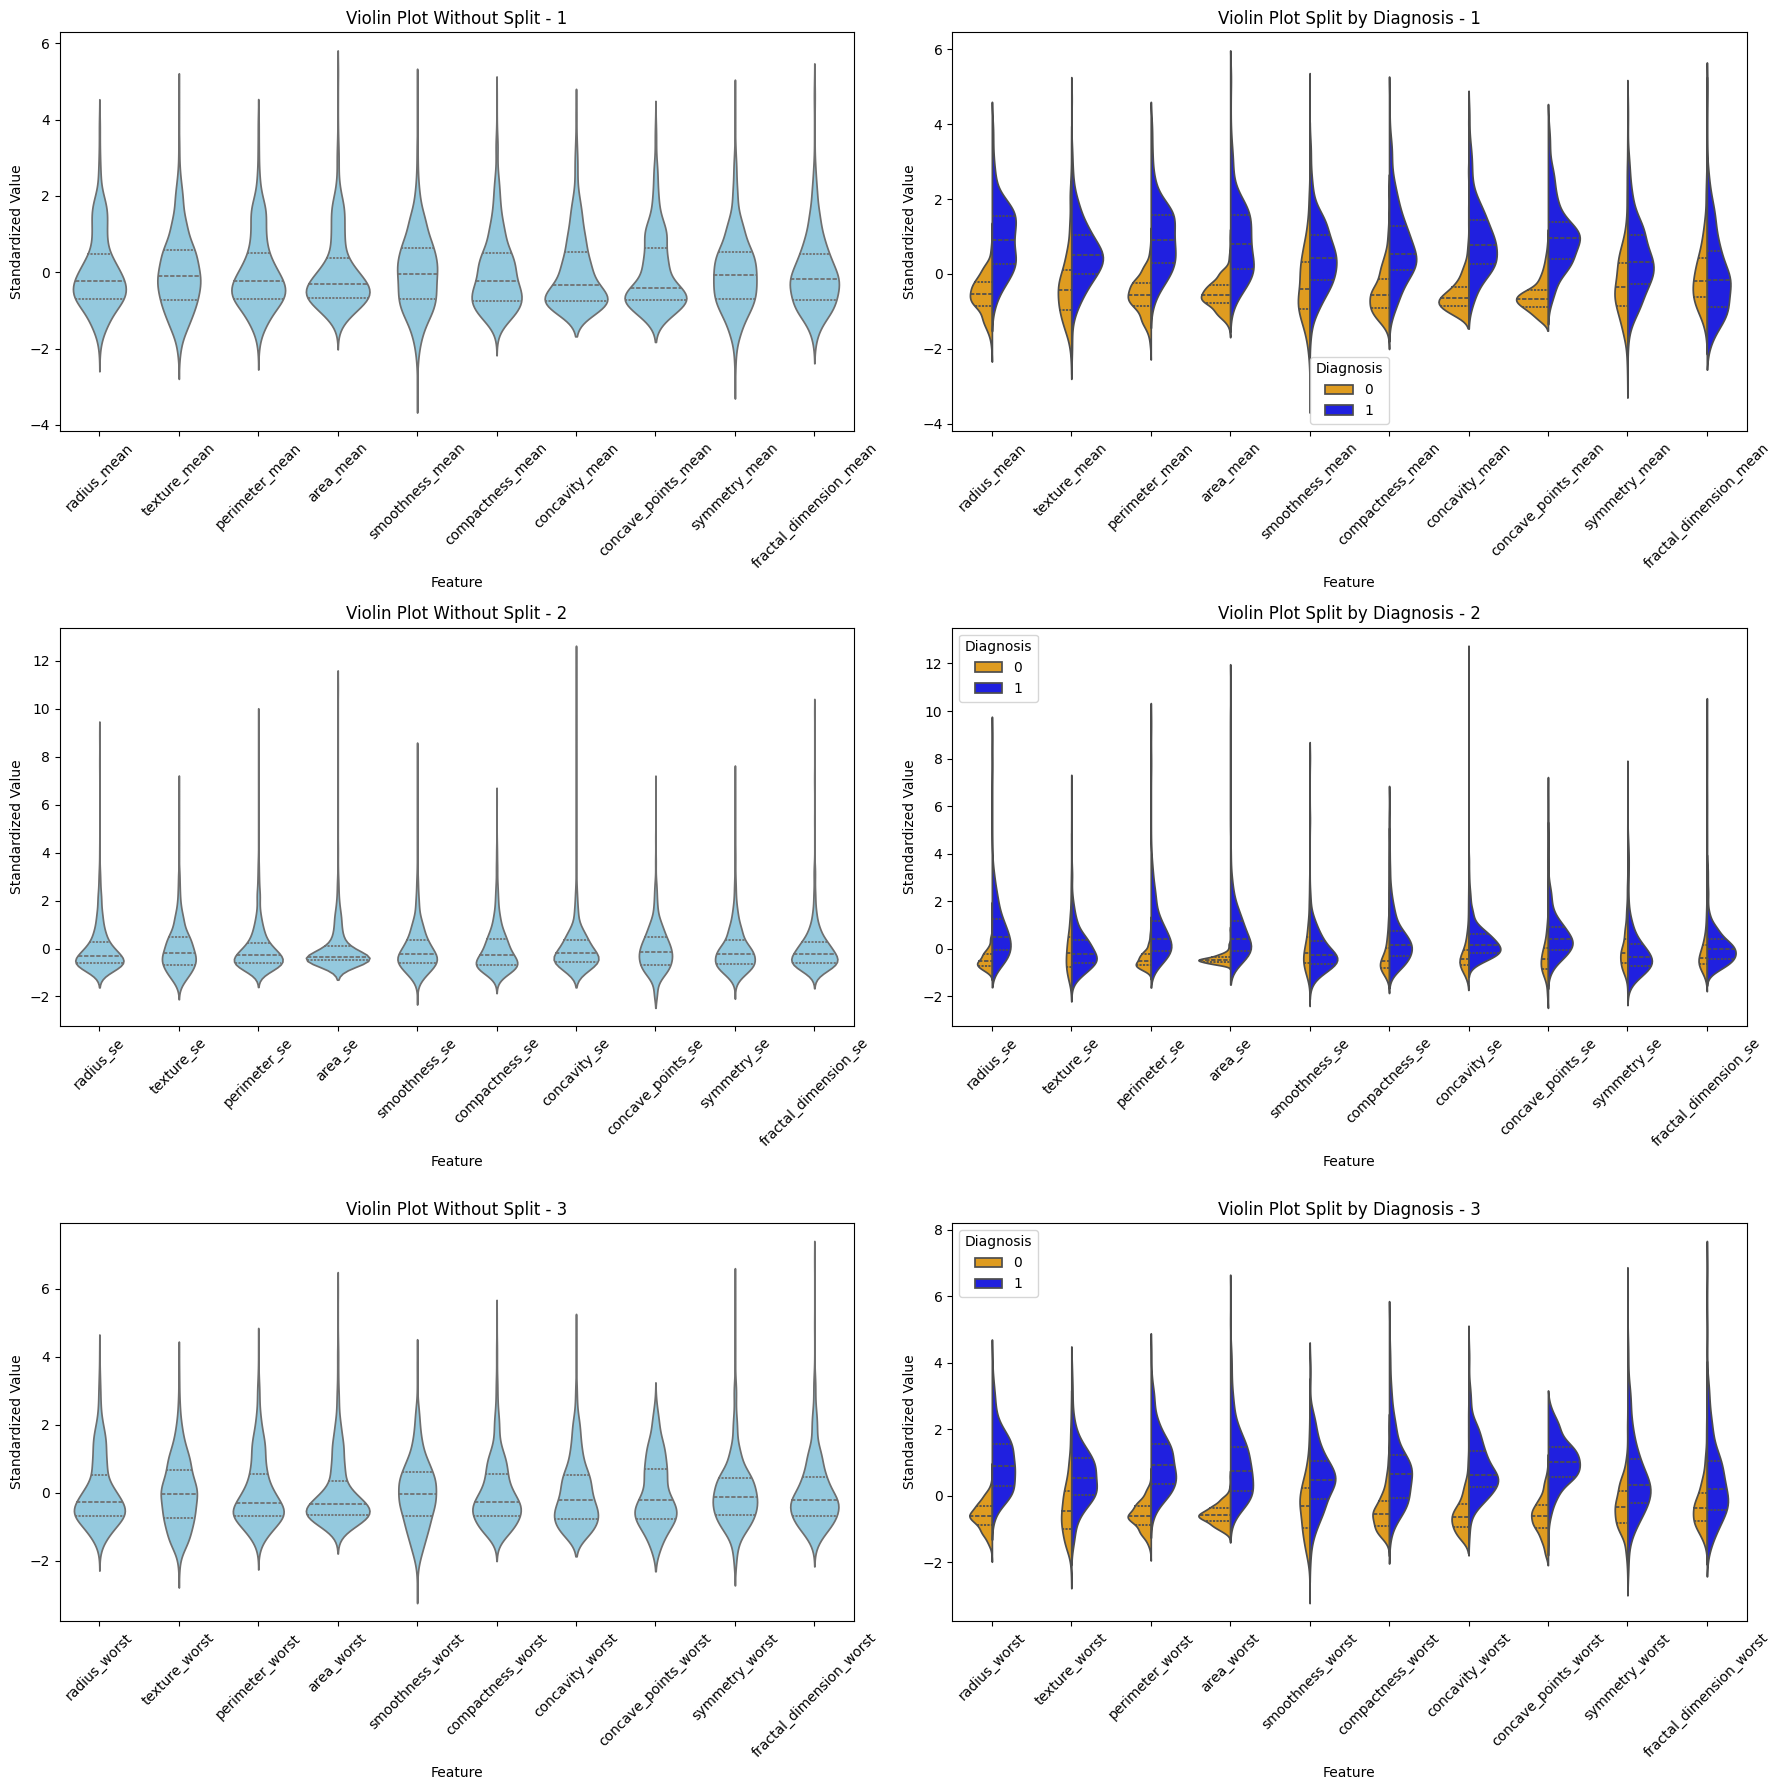

In [128]:
palette = {1: "blue", 0: "orange"}


fig, axes = plt.subplots(3, 2, figsize=(18, 18)) 

# List of feature sets for each row (customize as needed)
feature_groups = [
    mean_columns,  # Row 1, Left: Mean Features
    se_columns,    # Row 2, Left: SE Features
    worst_columns  # Row 3, Left: Worst Features
]

for i, ax_row in enumerate(axes):

    violin_plotter(df, feature_groups[i], ax=ax_row[0])
    ax_row[0].set_title(f"Violin Plot Without Split - {i+1}")

    violin_plotter(df, feature_groups[i], split_column="Diagnosis", palette=palette, ax=ax_row[1])
    ax_row[1].set_title(f"Violin Plot Split by Diagnosis - {i+1}")


plt.tight_layout()
plt.show()


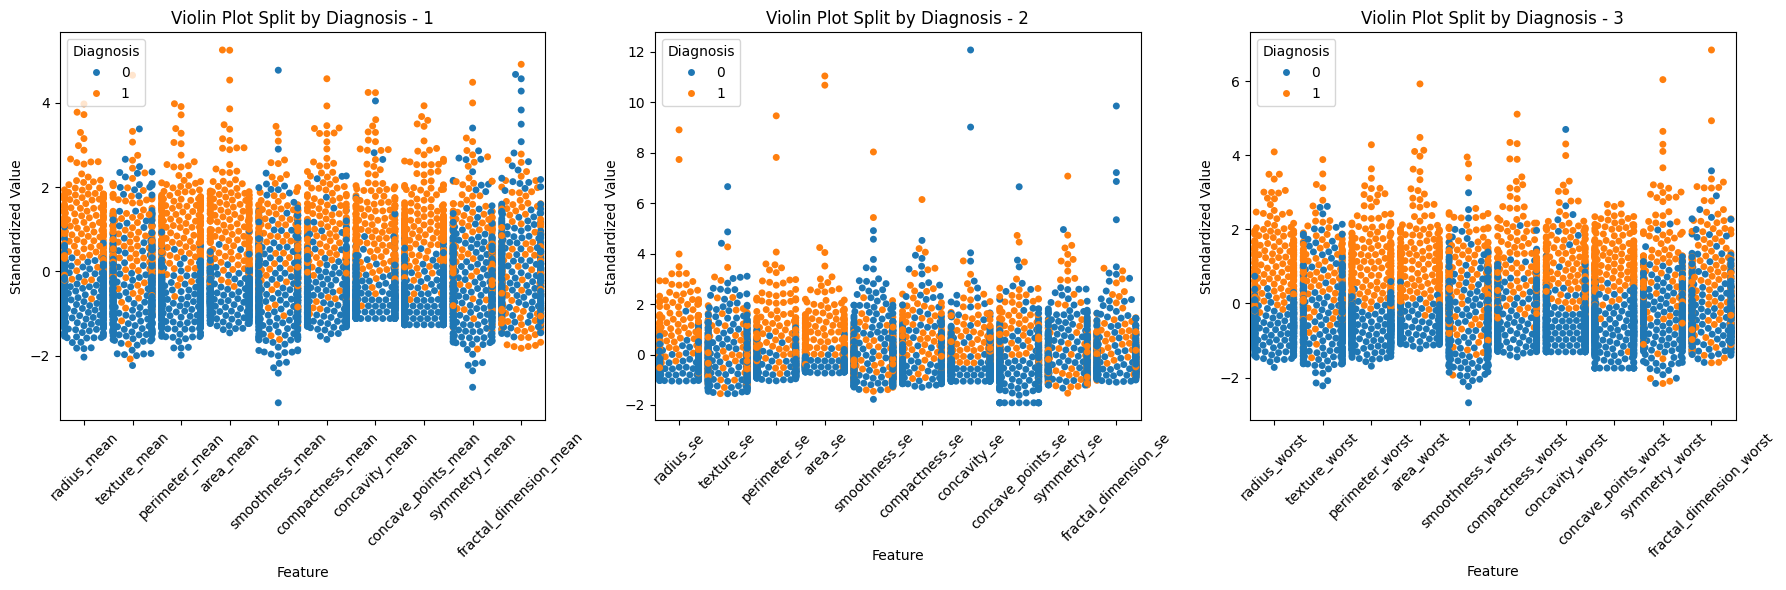

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusté la altura también

feature_groups = [
    mean_columns,
    se_columns,
    worst_columns
]

for i, ax in enumerate(axes):
    swarm_plotter(df, feature_groups[i], split_column="Diagnosis", ax=ax, palette=sns.color_palette() )
    ax.set_title(f"Violin Plot Split by Diagnosis - {i+1}")

plt.tight_layout()
plt.show()


## Correlaciones

Vamos a echar un vistazo a las correlaciones entre variables. Simplemente por los nombres de las variables ya podemos esperar correlaciones altas, pero debemos confirmar nuestras sospechas.

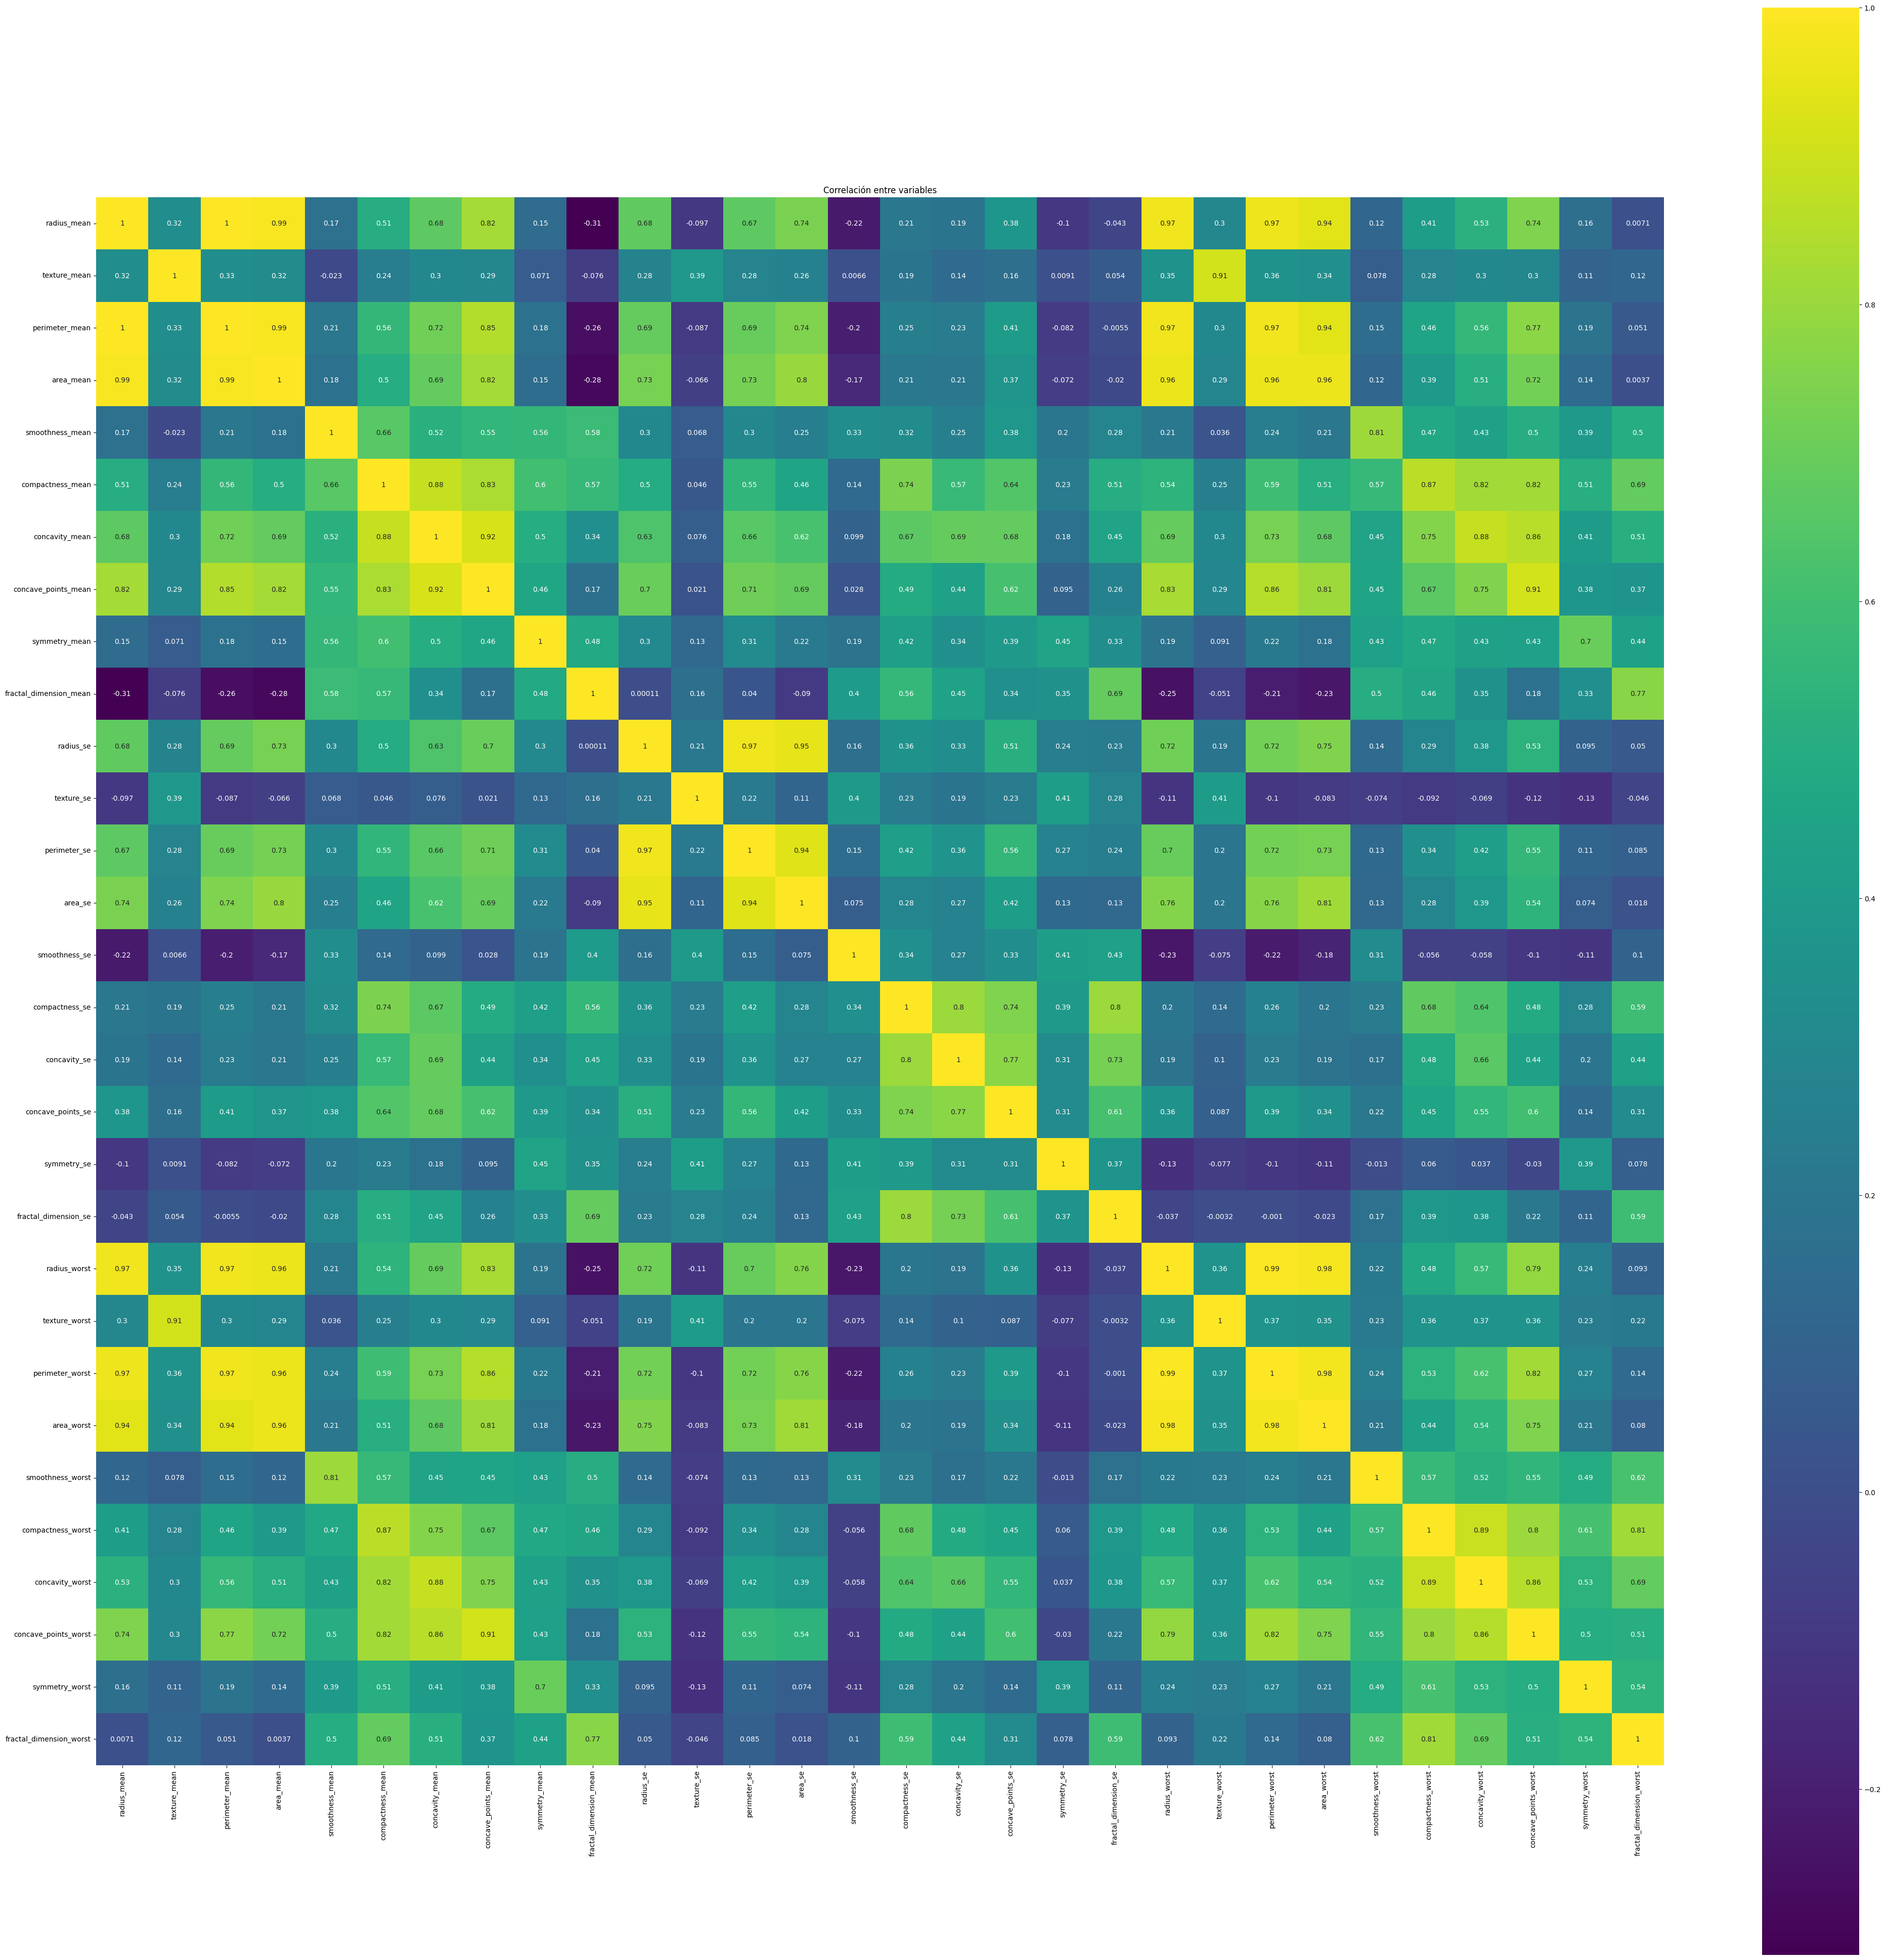

In [130]:
correlation = df[features].corr()
plt.figure(figsize=(50,50))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
plt.title('Correlación entre variables')
plt.show()

Como esperábamos, tenemos bloques altamente correlacionados:

- **Bloque 1**:
  - `radius_mean`
  - `perimeter_mean`
  - `area_mean`

- **Bloque 2**:
  - `compactness_mean`
  - `concavity_mean`
  - `concave_points_mean`

- **Bloque 3**:
  - `radius_se`
  - `perimeter_se`
  - `area_se`

- **Bloque 4**:
  - `compactness_se`
  - `concavity_se`
  - `concave_points_se`

- **Bloque 5**:
  - `radius_worst`
  - `perimeter_worst`
  - `area_worst`

- **Bloque 6**:
  - `compactness_worst`
  - `concavity_worst`
  - `concave_points_worst`

También tenemos **alta correlación entre los bloques 1 y 5**.


Vamos a guardar estos bloques en un diccionario para poder hacer más visualizaciones.

In [131]:
corr_blocks = {
    "block_mean_area": ["radius_mean", "perimeter_mean", "area_mean"],
    "block_mean_concav": ["compactness_mean", "concavity_mean", "concave_points_mean"],
    "block_se_area": ["radius_se", "perimeter_se", "area_se"],
    "block_se_concav": ["compactness_se", "concavity_se", "concave_points_se"],
    "block_worst_area": ["radius_worst", "perimeter_worst", "area_worst"],
    "block_worst_compact": ["compactness_worst", "concavity_worst", "concave_points_worst"],
}

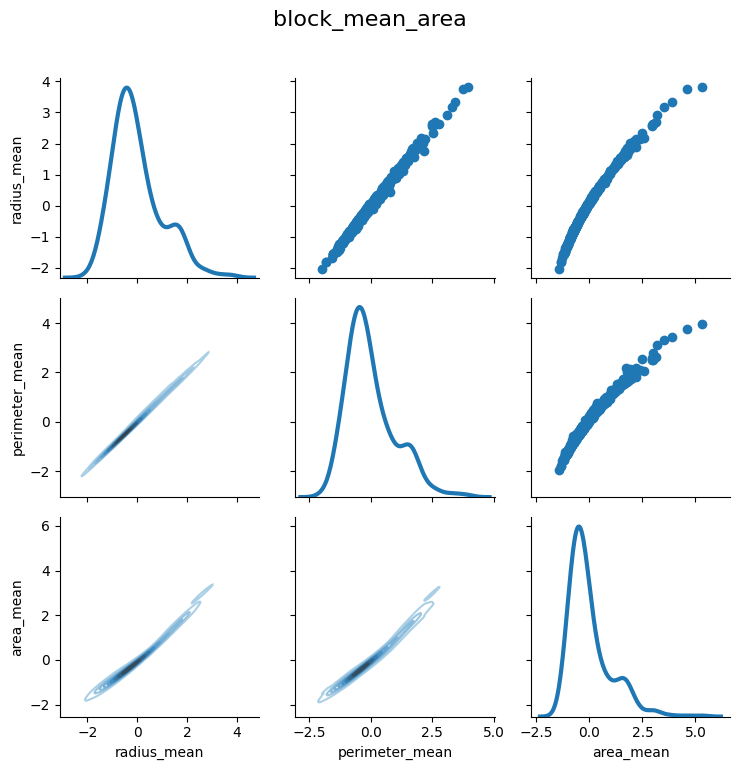

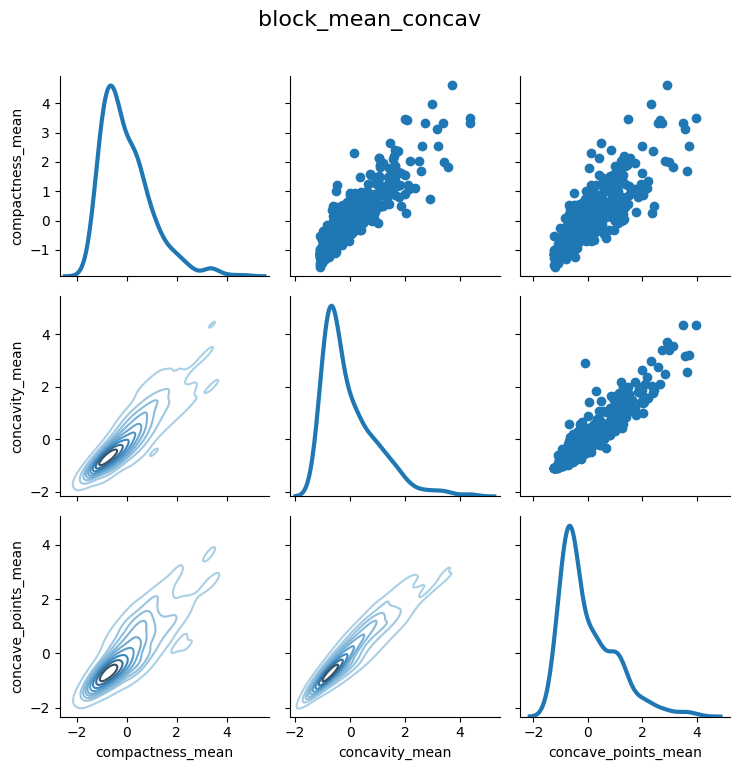

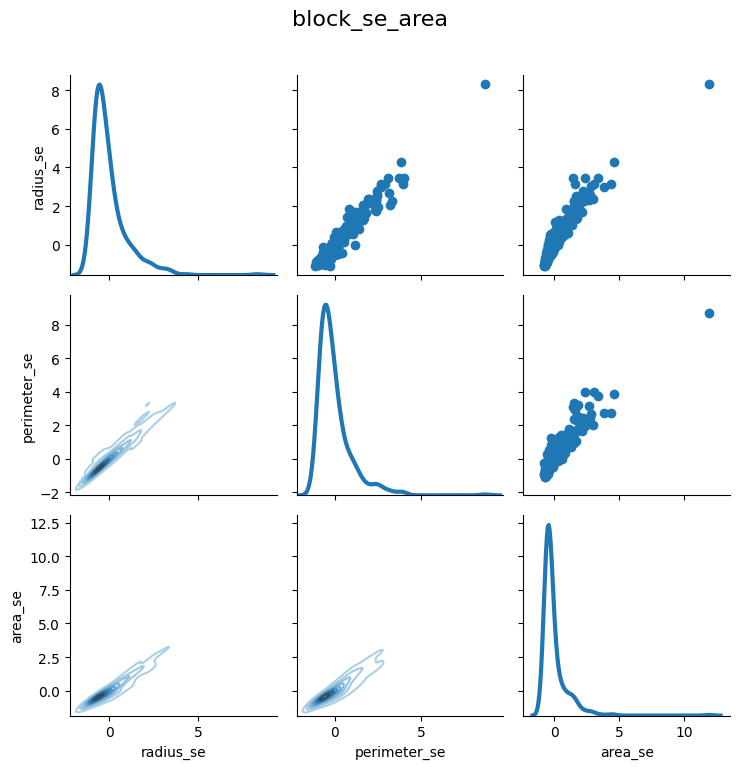

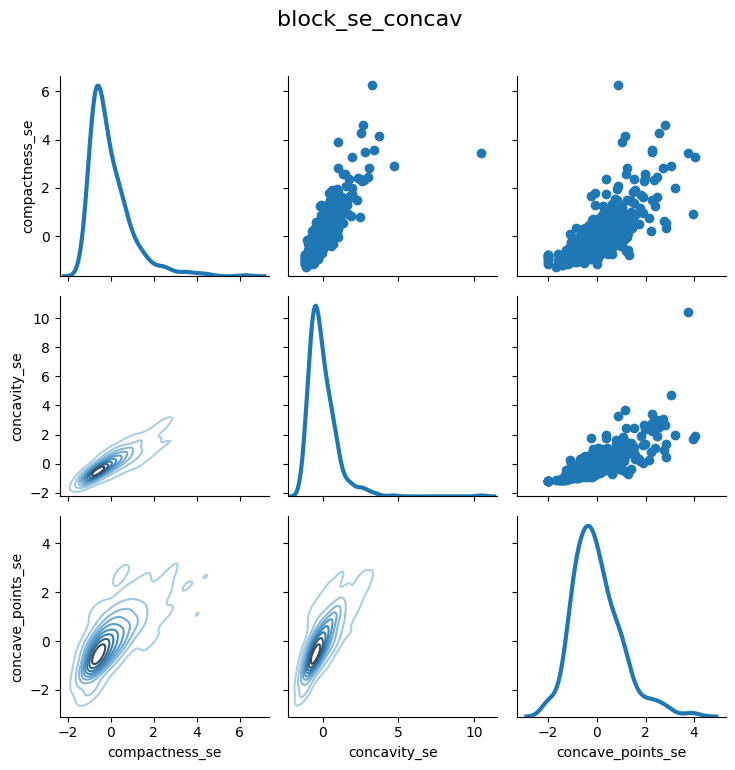

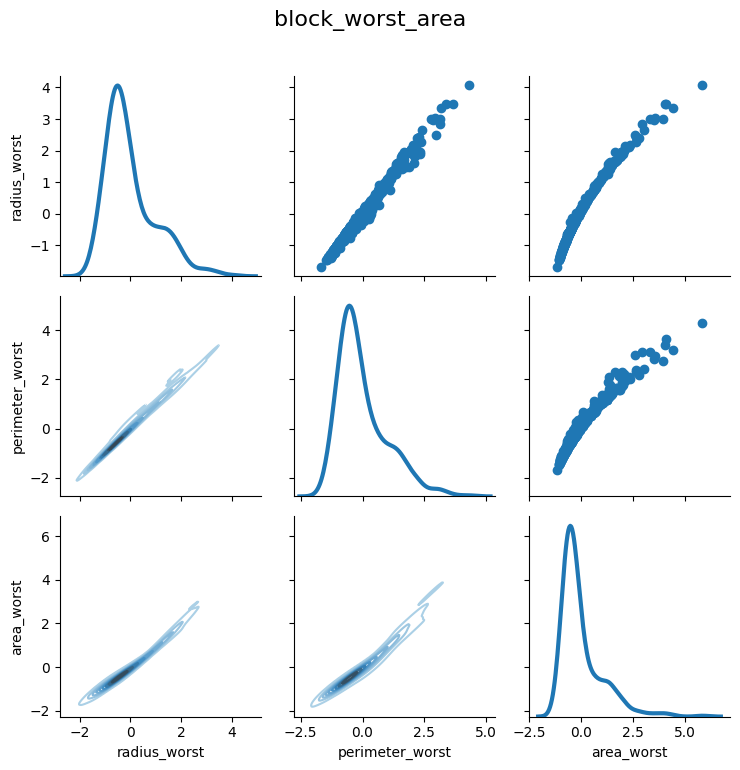

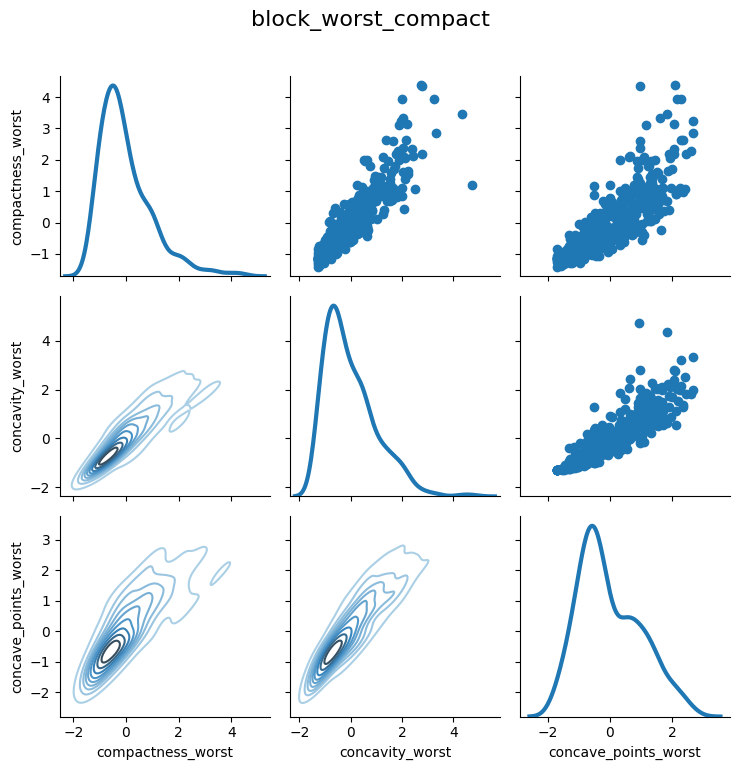

In [132]:
for block_name, features_corr in corr_blocks.items():
    g = sns.PairGrid(df_train_scaled[features_corr], diag_sharey=False)
    g.map_lower(sns.kdeplot, cmap="Blues_d")
    g.map_upper(plt.scatter)
    g.map_diag(sns.kdeplot, lw=3)
    g.fig.suptitle(block_name, fontsize=16, y=1.02)  # optional title
    plt.tight_layout()
    plt.show()


In [133]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave_points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave_points_worst','compactness_se','concave_points_se','texture_worst']
df_train_scaled_filtered = df_train_scaled.drop(drop_list1,axis = 1 )        # do not modify x, we will use it later 
df_train_scaled_filtered.head()


,texture_mean,area_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,area_worst,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
244,1.023,1.453,0.461,1.521,0.622,-0.366,1.125,0.502,1.345,0.321,0.170,0.128,0.934,0.635,0.377,0.046,-0.407,1
129,1.404,1.559,0.376,2.156,1.447,-0.202,-0.004,0.571,-0.706,0.642,-0.563,-0.178,1.231,-0.203,1.442,0.678,0.085,1
332,0.167,-0.751,0.653,-1.036,0.482,-0.325,1.433,-0.467,2.184,-1.049,2.649,-0.709,-0.757,0.461,-1.220,0.656,-1.039,0
352,-0.398,3.908,1.329,3.209,0.541,-0.190,-0.656,2.704,-0.214,0.455,0.349,-0.110,4.068,0.933,1.816,1.309,0.288,1
423,-0.005,-0.211,-0.401,0.135,0.143,-0.103,-0.574,-0.473,-1.093,0.227,-0.559,0.131,-0.287,-0.774,0.475,-0.243,0.302,0


In [134]:
filtered_features = [f for f in features if f not in drop_list1]

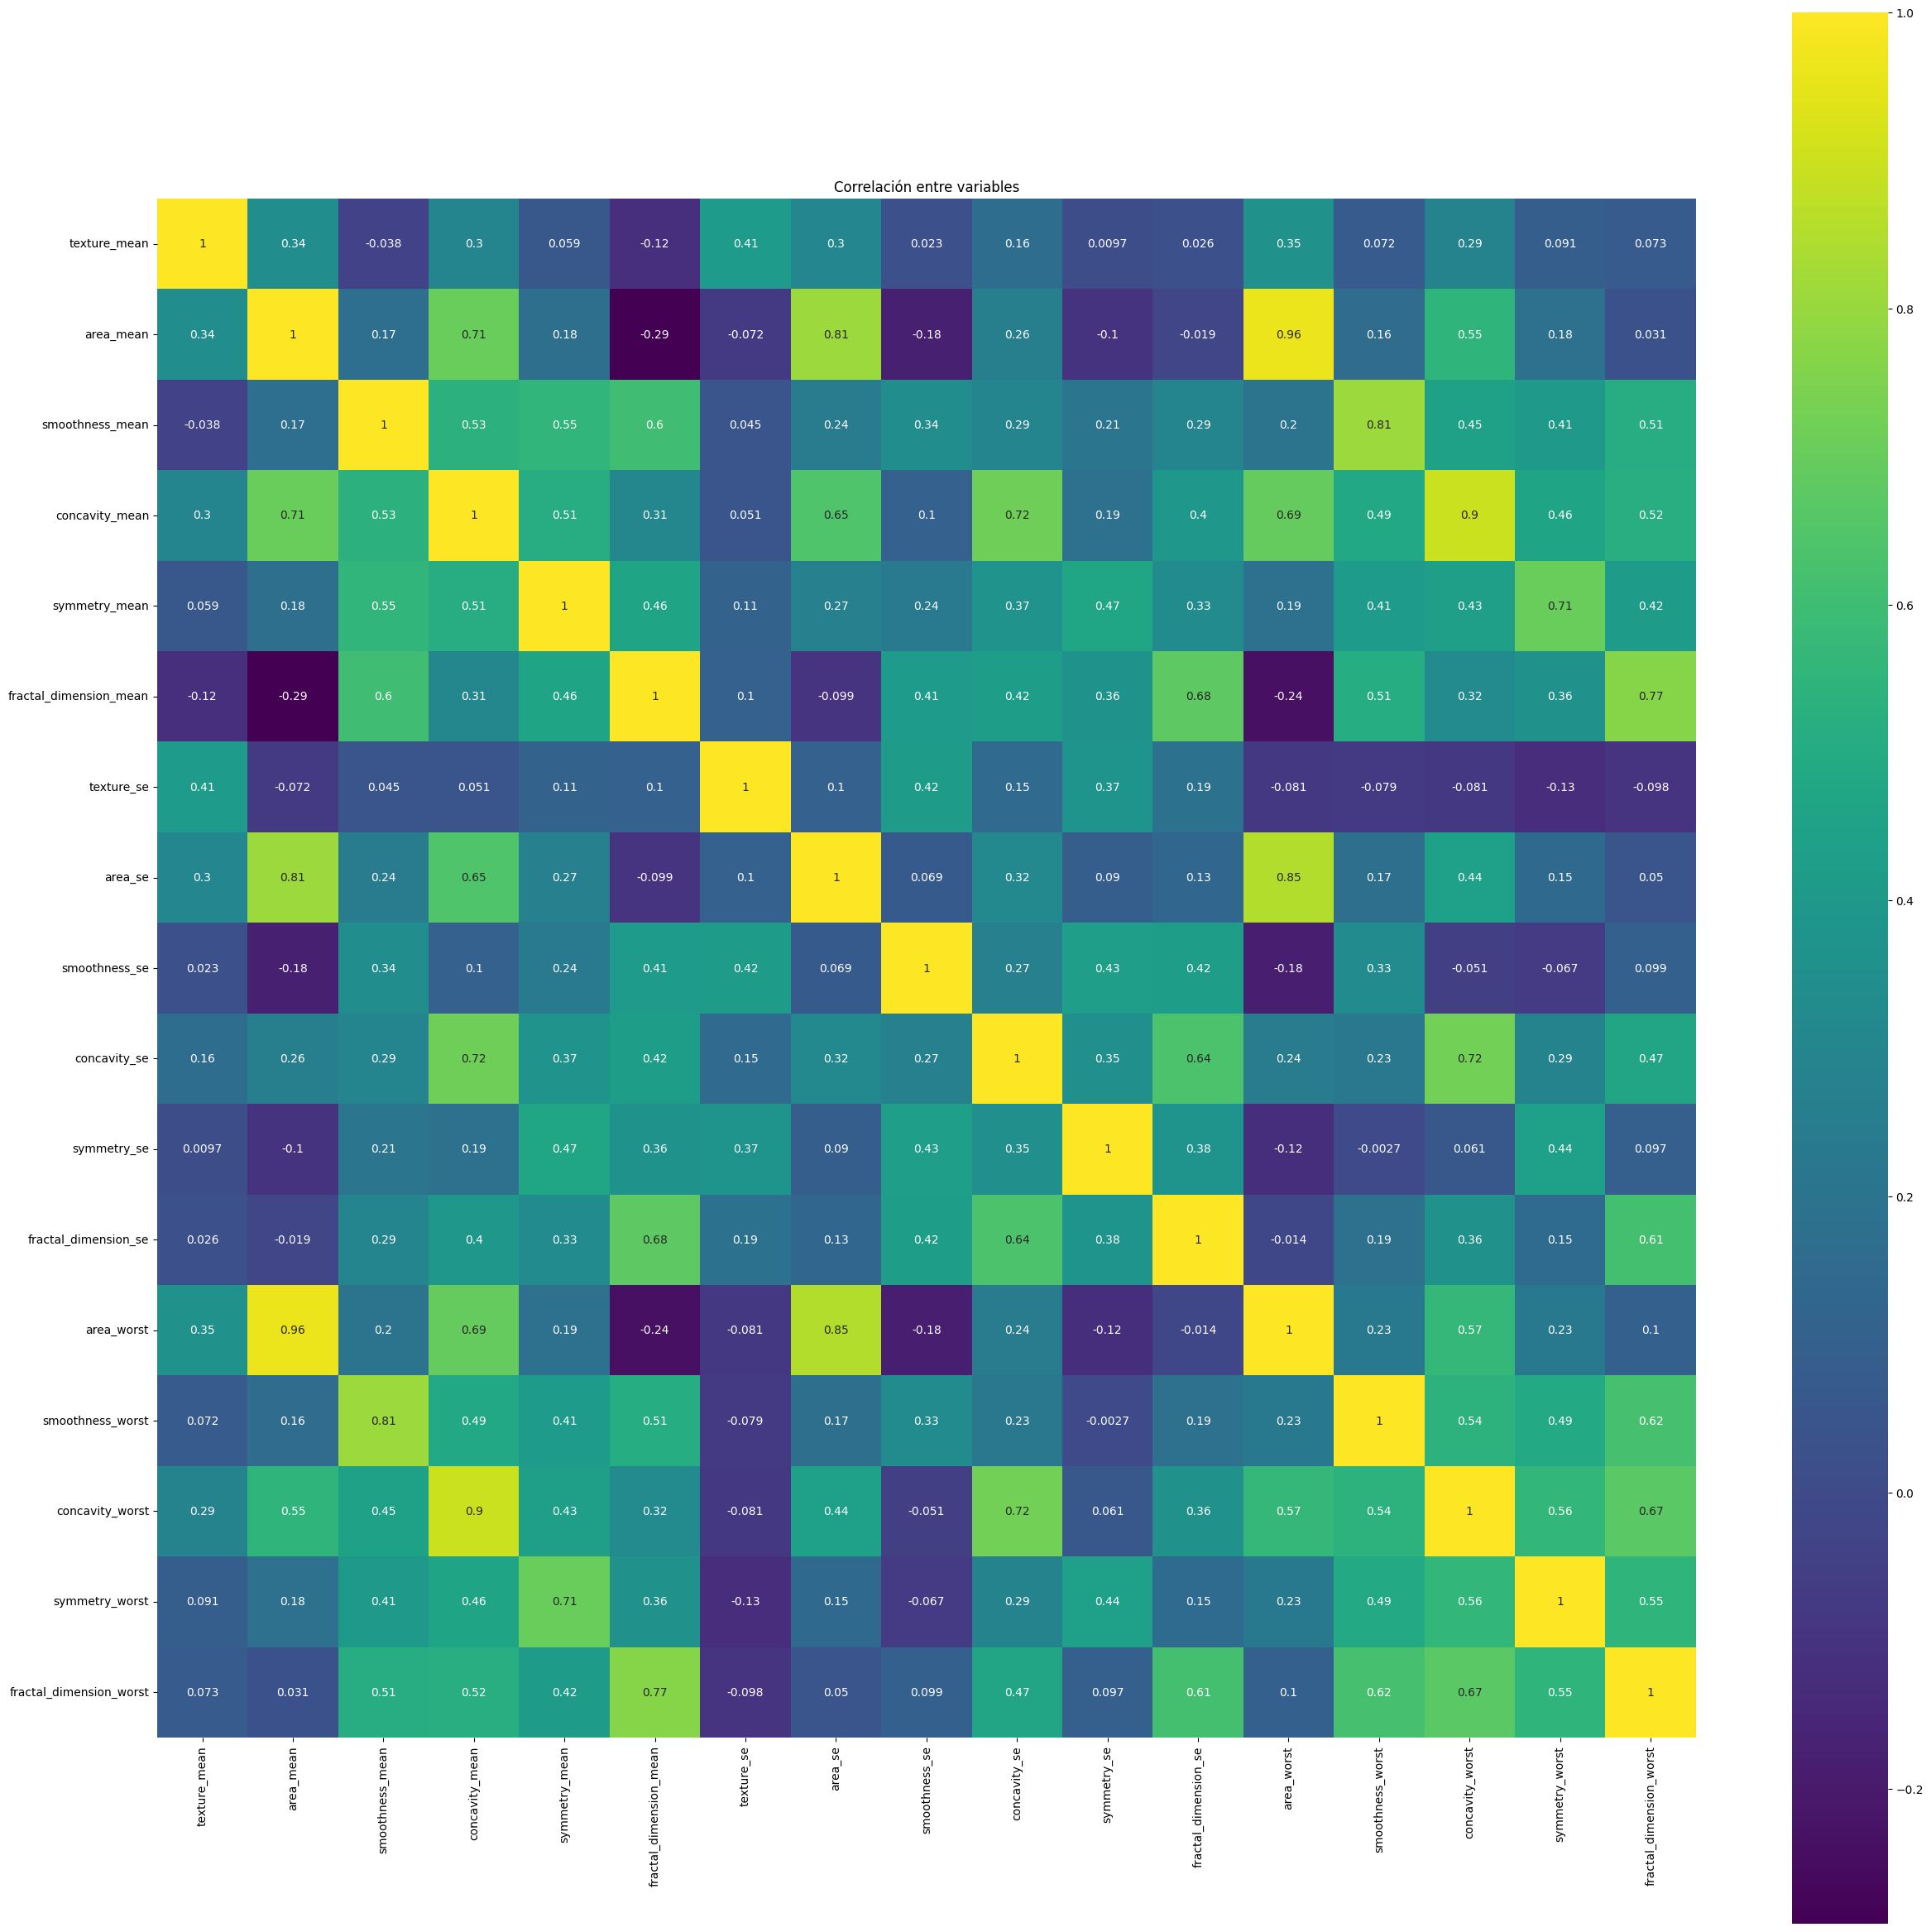

In [135]:
correlation =df_train_scaled[filtered_features].corr()
plt.figure(figsize=(30,30))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
plt.title('Correlación entre variables')
plt.show()

## Feature importance

In [136]:
X_train=df_train_scaled[features]
y_train=df_train_scaled[target]

X_train_filtered=df_train_scaled[filtered_features]
y_train_filtered=df_train_scaled[target]

Hemos llevado a cabo una preselección de variables usando simplemente las correlaciones. Uno de los objetivos de esta preselección era poder usar `feature_importances` de los bosques aleatorios. Este método nos permite averiguar que características son importantes para distinguir los casos benignos y malignos ajustando un bosque aleatorio a los datos  y viendo que características aparecen más frecuentemente en la construcción de los distintos árboles. Una frecuencia de aparición alta quiere decir que es una característica que normalmente presenta el mejor umbral de corte para distinguir entre casos positivos y negativos.

Este método puede verse afectado por la colinealidad, puesto que si dos características son colineales o altamente correladas, ambas representarán umbrales esencialmente equivalentes, por lo que podemos esperar que el algoritmo de bosques aleatorios escoja una de ellas con probabilidad uniforme (si hay dos, probabilidad $\frac{1}{2}$, si hay $n$ variables altamente colineales por pares, probabilidad aproximadamente $\frac{1}{n}$). Lo cual daría una importancia aparente mucho más baja a las variables que la que en realidad les corresponde.

In [137]:
def get_feature_importances(features :pd.DataFrame, target: pd.DataFrame, n_trees : int, n_runs: int =1, ax=None) -> Tuple[pd.DataFrame, plt.figure, plt.axes]:
    # Store feature importances for each run
    feature_importances = np.zeros((n_runs, features.shape[1]))

    # Run Random Forest multiple times
    for i in range(n_runs):
        rnf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1)
        rnf.fit(features, target)
        feature_importances[i, :] = rnf.feature_importances_

    # Compute the average and standard deviation of feature importance
    avg_importances = feature_importances.mean(axis=0)
    std_importances = feature_importances.std(axis=0)

    # Convert to Pandas Series for visualization   
    feat_importances = pd.Series(avg_importances, index=features.columns).sort_values(ascending=True)
    std_sorted = pd.Series(std_importances, index=features.columns).loc[feat_importances.index]

    feature_importance_df = pd.DataFrame({
    'Feature': feat_importances.index,
    'Importance': feat_importances.values,
    'Std Dev': std_sorted.values})
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
        created_figure = True
    else:
        fig = ax.figure
        created_figure = False


    ax.barh(feature_importance_df['Feature'], 
            feature_importance_df['Importance'], 
            xerr=feature_importance_df['Std Dev'], 
            capsize=5, 
            color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df))))

    ax.set_xlabel("Feature Importance")
    ax.set_ylabel("Features")
    ax.set_title("Feature Importance with Error Bars (Random Forest)")
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    if created_figure:
        plt.close(fig)

    return feature_importance_df, fig, ax



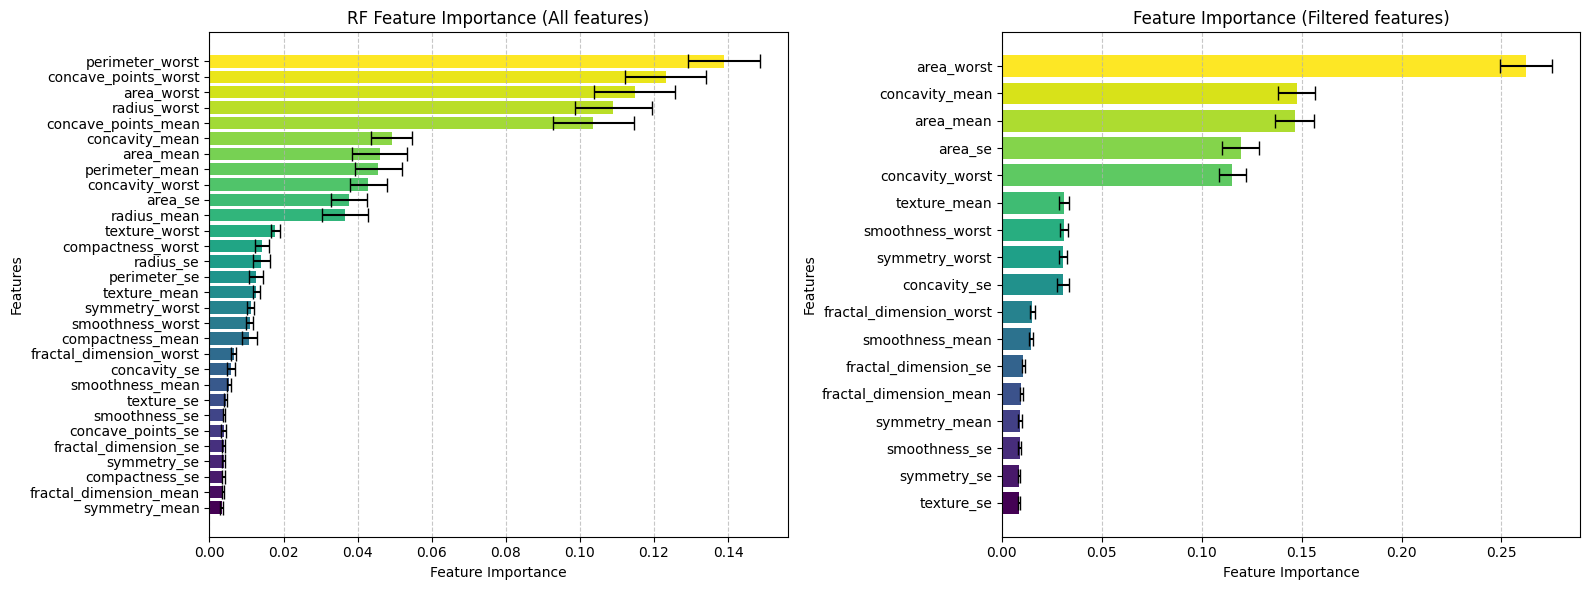

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_feat_imp_unfiltered, _, _ = get_feature_importances(X_train, y_train, 500, n_runs=50, ax=axes[0])
axes[0].set_title("RF Feature Importance (All features)")

df_feat_imp_filtered, _, _ = get_feature_importances(X_train_filtered, y_train_filtered, 500, n_runs=50, ax=axes[1])
axes[1].set_title("Feature Importance (Filtered features)")

plt.tight_layout()
plt.show()


In [139]:
top_11_imp_features = df_feat_imp_filtered.sort_values(by="Importance", ascending=False).head(11)["Feature"].tolist()
top_5_imp_features = df_feat_imp_filtered.sort_values(by="Importance", ascending=False).head(5)["Feature"].tolist()

# Model training

In [140]:
X_train=df_train_scaled[features]
y_train=df_train_scaled[target]

X_train_filtered=df_train_scaled[filtered_features]
y_train_filtered=df_train_scaled[target]


X_train_filtered_top11=df_train_scaled[top_11_imp_features]
y_train_filtered_top11=df_train_scaled[target]

X_train_filtered_top5=df_train_scaled[top_5_imp_features]
y_train_filtered_top5=df_train_scaled[target]

In [173]:
from sklearn.model_selection import cross_validate


def evaluate_models(model, datasets, scoring='accuracy'):
    results = []

    for label, (X, y) in datasets.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)

        result = {"Dataset": label}

        if isinstance(scoring, dict):
            metric_names = scoring.keys()
        elif isinstance(scoring, list):
            metric_names = scoring
        else:
            metric_names = [scoring]

        for metric in metric_names:
            score_key = f'test_{metric}' if isinstance(scoring, (list, dict)) else 'test_score'
            scores = cv_results[score_key]
            result[f"{metric} Mean"] = np.mean(scores)
            result[f"{metric} Std"] = np.std(scores)

        results.append(result)

    return pd.DataFrame(results)


In [175]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def cross_val_confusion(model, X, y, cv=5):
    y_pred = cross_val_predict(model, X, y, cv=cv)
    
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, target_names=["Benign", "Malignant"])
    
    print("Classification Report:")
    print(report)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
    disp.plot(cmap="Blues")


In [143]:

from sklearn.metrics import make_scorer, recall_score

# Custom recall scorer focusing on malignant class (1)
malignant_recall = make_scorer(recall_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall_macro': 'recall_macro',
    'malignant_recall': malignant_recall
}


## Voting

In [144]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)

datasets = {
    "All Features": (X_train, y_train),
    "Filtered Features": (X_train_filtered, y_train_filtered),
    "Top 11 Important": (X_train_filtered_top11, y_train_filtered_top11),
    "Top 5 Important": (X_train_filtered_top5, y_train_filtered_top5)
}

results_df=evaluate_models(voting, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.976,0.016,0.973,0.019,0.964,0.035
1,Filtered Features,0.976,0.011,0.972,0.014,0.958,0.031
2,Top 11 Important,0.969,0.013,0.964,0.018,0.945,0.040
3,Top 5 Important,0.945,0.010,0.939,0.013,0.915,0.030


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       290
   Malignant       0.97      0.95      0.96       165

    accuracy                           0.97       455
   macro avg       0.97      0.96      0.97       455
weighted avg       0.97      0.97      0.97       455



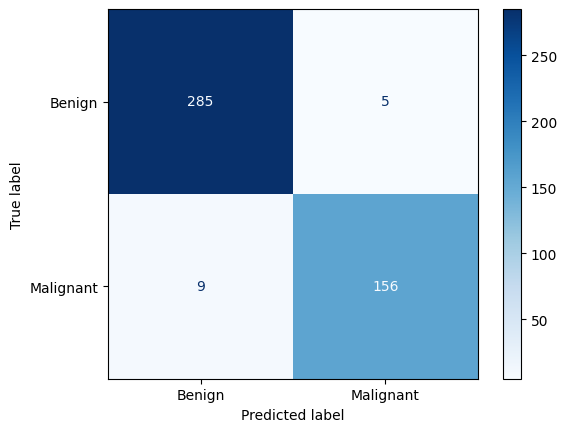

In [176]:
cross_val_confusion(voting, X_train_filtered_top11, y_train_filtered_top11)


## Bagging

In [145]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [146]:
bagging_tree = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,  # Número de modelos en el ensamble
    random_state=42
)

results_df=evaluate_models(bagging_tree, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.958,0.019,0.950,0.027,0.921,0.059
1,Filtered Features,0.949,0.025,0.942,0.028,0.915,0.045
2,Top 11 Important,0.958,0.016,0.952,0.020,0.927,0.041
3,Top 5 Important,0.943,0.015,0.939,0.017,0.927,0.031


## Random forest and extra trees

In [147]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

results_df=evaluate_models(rf, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.956,0.014,0.949,0.016,0.921,0.031
1,Filtered Features,0.965,0.015,0.957,0.020,0.927,0.041
2,Top 11 Important,0.969,0.015,0.963,0.018,0.939,0.033
3,Top 5 Important,0.938,0.015,0.932,0.017,0.909,0.027


In [148]:
et = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

results_df=evaluate_models(et, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.969,0.018,0.963,0.024,0.939,0.051
1,Filtered Features,0.963,0.015,0.956,0.025,0.933,0.062
2,Top 11 Important,0.965,0.011,0.958,0.018,0.933,0.052
3,Top 5 Important,0.949,0.011,0.942,0.013,0.915,0.023


## Boosting

In [149]:
from xgboost import XGBClassifier

In [150]:
xgb_tree = XGBClassifier(eval_metric='logloss')

results_df=evaluate_models(xgb_tree, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.974,0.011,0.971,0.012,0.964,0.023
1,Filtered Features,0.969,0.018,0.964,0.019,0.945,0.023
2,Top 11 Important,0.963,0.018,0.959,0.018,0.945,0.023
3,Top 5 Important,0.945,0.021,0.939,0.025,0.915,0.040


In [151]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

logistic_base = LogisticRegression()

adaboost_logistic = AdaBoostClassifier(
    estimator=logistic_base,
    n_estimators=50,
    algorithm="SAMME.R",
    random_state=42
)

results_df=evaluate_models(adaboost_logistic, datasets, scoring=scoring)
results_df


,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.978,0.018,0.976,0.016,0.970,0.019
1,Filtered Features,0.976,0.018,0.972,0.018,0.958,0.024
2,Top 11 Important,0.982,0.011,0.980,0.013,0.970,0.027
3,Top 5 Important,0.938,0.016,0.932,0.024,0.909,0.051


## Staking

In [152]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

stack1 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

results_df=evaluate_models(stack1, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.963,0.018,0.958,0.020,0.939,0.033
1,Filtered Features,0.956,0.022,0.952,0.023,0.939,0.033
2,Top 11 Important,0.960,0.016,0.956,0.019,0.939,0.033
3,Top 5 Important,0.941,0.009,0.935,0.010,0.915,0.023


In [153]:
from sklearn.linear_model import RidgeClassifier

stack2 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('logreg', LogisticRegression(max_iter=1000)),
        ('et', ExtraTreesClassifier(n_estimators=100, random_state=42))
    ],
    final_estimator=RidgeClassifier(),
    cv=5
)

results_df=evaluate_models(stack2, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.980,0.013,0.975,0.016,0.958,0.031
1,Filtered Features,0.974,0.011,0.968,0.012,0.945,0.023
2,Top 11 Important,0.978,0.012,0.972,0.018,0.952,0.041
3,Top 5 Important,0.941,0.011,0.935,0.014,0.915,0.030


In [154]:
stack4 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('gb', GradientBoostingClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
results_df=evaluate_models(stack4, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.963,0.018,0.958,0.020,0.939,0.033
1,Filtered Features,0.958,0.018,0.954,0.019,0.939,0.033
2,Top 11 Important,0.958,0.018,0.954,0.019,0.939,0.033
3,Top 5 Important,0.941,0.005,0.934,0.008,0.909,0.019


# Afinación de hiperparámetros

In [161]:
X_test_filtered_top11=df_test_scaled[top_11_imp_features]
y_test_filtered_top11=df_test_scaled[target]

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss')

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 500, 1000, 1500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

scoring = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,  # <-- Focus on recall for malignant
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_filtered_top11, y_train_filtered_top11)

# Best model
best_params = grid_search.best_params_
cv_score=grid_search.best_score_  

print(f"Best Params: {grid_search.best_params_}")
print(f"Cross-Validated score: {cv_score}")


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.8}
Cross-Validated score: 0.9454545454545455


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [171]:

final_model = XGBClassifier(eval_metric='logloss', **best_params)
final_model.fit(X_train_filtered_top11, y_train_filtered_top11)

y_pred = final_model.predict(X_test_filtered_top11)

print(classification_report(y_test_filtered_top11, y_pred, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.97      1.00      0.99        71
   Malignant       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



Benign recall is easier to achieve if it has more consistent features
It’s possible that:

Benign cases have more regular, well-separated features

Malignant cases are more diverse or noisy, which makes them harder to catch all the time

So your model naturally finds it easier to classify benign samples with higher recall — even while prioritizing malignant during tuning.

# Interpretabilidad

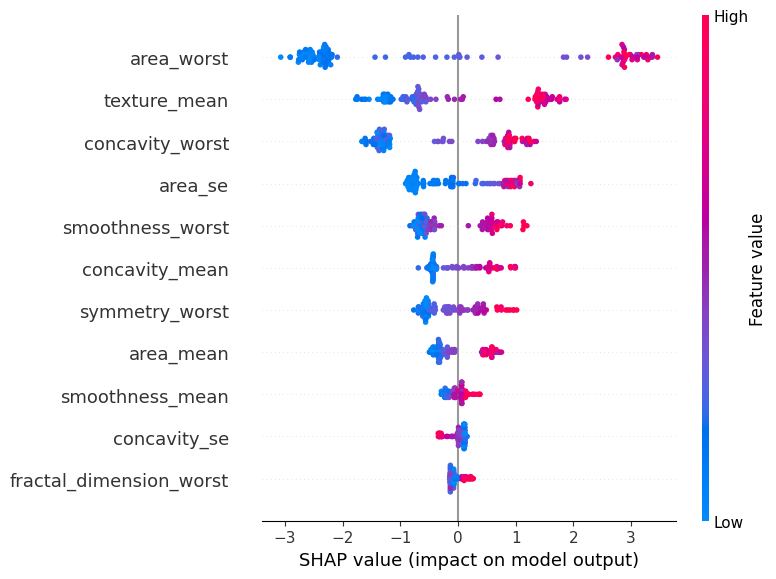

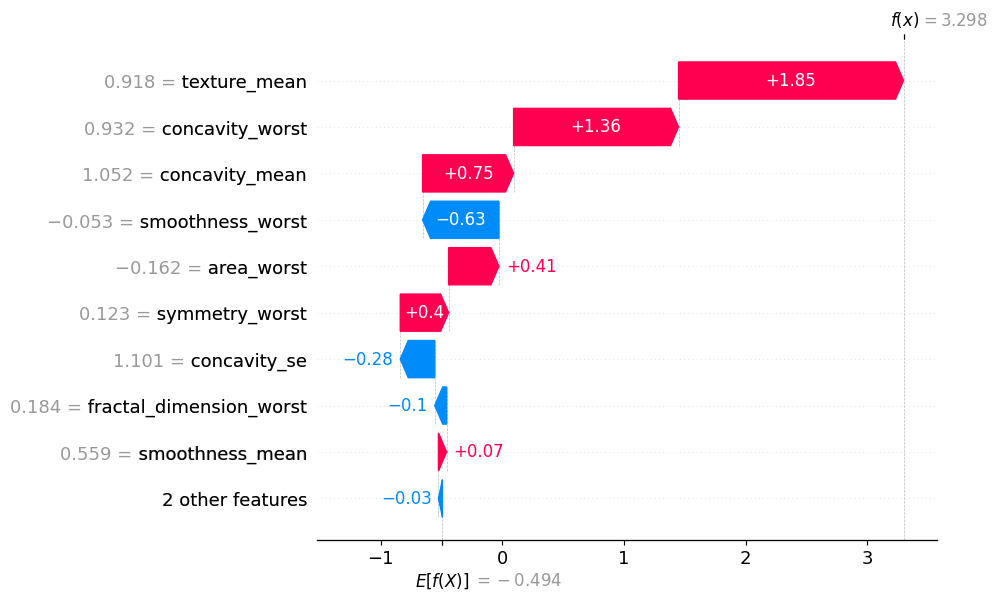

In [167]:
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test_filtered_top11)

# Summary plot (Global feature importance)
shap.summary_plot(shap_values, X_test_filtered_top11)

# Waterfall plot for a specific company (first instance in test set)
shap.waterfall_plot(shap_values[0])

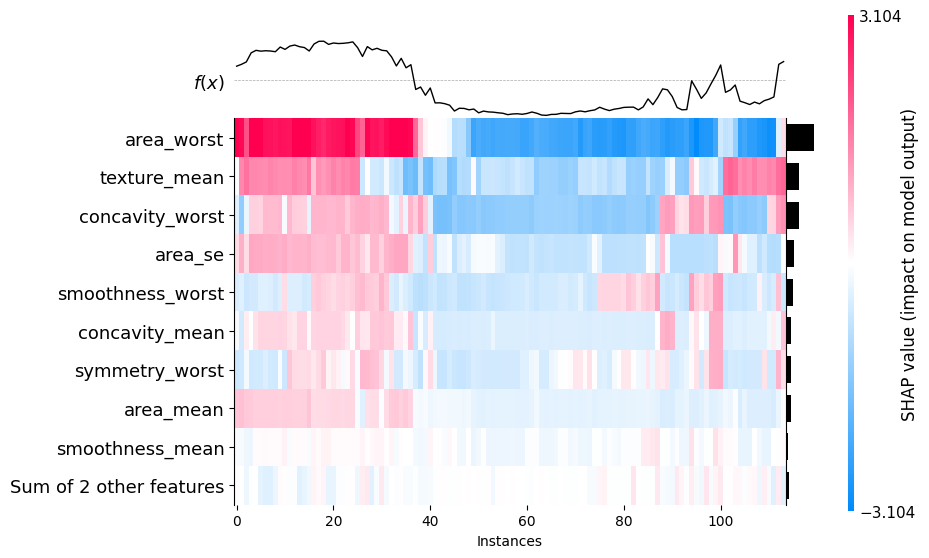

<Axes: xlabel='Instances'>

In [168]:
shap.plots.heatmap(shap_values)

In [169]:
force_plot=shap.plots.force(shap_values)
shap.save_html("shap_force_plot.html", force_plot)

print("SHAP force plot saved as 'shap_force_plot.html'. Open it in a browser.")

SHAP force plot saved as 'shap_force_plot.html'. Open it in a browser.


# Extra